# Importing Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loading the datasets

In [2]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Device Configuration

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Hyperparameters

In [4]:
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCH = 20

# Load the Data using DataLoader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# AutoEncoder Model

In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1,1),kernel_size=(3,3), padding=1), # 28x28x1 -> 28x28x32
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2,2),kernel_size=(3,3), padding=1), # 28x28x32 -> 14x14x64
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2,2),kernel_size=(3,3), padding=1), # 14x14x64 -> 7x7x64
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(1,1),kernel_size=(3,3), padding=1), # 7x7x64 -> 7x7x64
            nn.Flatten(),
            nn.Linear(3136, 2) # 3136 -> 2
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 3136),   # 2 -> 3136
            Reshape(-1, 64, 7, 7),  # 3136 -> 7x7x64
            nn.ConvTranspose2d(64, 64, stride=(1,1),kernel_size=(3,3), padding=1),  # 7x7x64 -> 7x7x64
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=(2,2),kernel_size=(3,3), padding=1), # 7x7x64 -> 14x14x64
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, stride=(2,2),kernel_size=(3,3), padding=0), # 14x14x64 -> 29x29x32
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 1, stride=(1,1),kernel_size=(3,3), padding=0),  # 29x29x32 -> 29x29x1
            Trim(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def test():
    x = torch.randn(32, 1, 28, 28)
    model = AutoEncoder()
    preds = model(x)
    assert preds.shape == x.shape

test()

# Define Loss function, Optimizer and Initializiing the Model

In [7]:
loss = nn.MSELoss()
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Model Training

In [8]:
train_loss = []
test_loss = []

def train(model, optimizer, loss_fn, trainloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = loss_fn(outputs, inputs)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()

    train_loss.append(running_loss / len(trainloader))
    print(f"Training | Loss: {running_loss / len(trainloader)}")

def test(model, loss_fn, testloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_value = loss_fn(outputs, inputs)

            running_loss += loss_value.item()
    test_loss.append(running_loss / len(testloader))
    print(f"Testing | Loss: {running_loss / len(testloader)}")

# Training loop
for epoch in range(EPOCH):
    print(f"EPOCH {epoch + 1}")
    train(model, optimizer, loss, train_loader, device)
    test(model, loss, test_loader, device)

EPOCH 1


Training: 100%|██████████| 1875/1875 [00:25<00:00, 72.43it/s] 


Training | Loss: 0.050368766472737


Testing: 100%|██████████| 313/313 [00:01<00:00, 172.68it/s]


Testing | Loss: 0.04529415380459624
EPOCH 2


Training: 100%|██████████| 1875/1875 [00:17<00:00, 108.72it/s]


Training | Loss: 0.04412348663806915


Testing: 100%|██████████| 313/313 [00:02<00:00, 140.39it/s]


Testing | Loss: 0.043301728812936015
EPOCH 3


Training: 100%|██████████| 1875/1875 [00:16<00:00, 110.95it/s]


Training | Loss: 0.0427937390267849


Testing: 100%|██████████| 313/313 [00:01<00:00, 174.70it/s]


Testing | Loss: 0.04256418190253809
EPOCH 4


Training: 100%|██████████| 1875/1875 [00:16<00:00, 111.57it/s]


Training | Loss: 0.041976181596517566


Testing: 100%|██████████| 313/313 [00:02<00:00, 129.43it/s]


Testing | Loss: 0.04179044315418877
EPOCH 5


Training: 100%|██████████| 1875/1875 [00:17<00:00, 104.38it/s]


Training | Loss: 0.04145500055551529


Testing: 100%|██████████| 313/313 [00:01<00:00, 164.95it/s]


Testing | Loss: 0.04123137044473388
EPOCH 6


Training: 100%|██████████| 1875/1875 [00:16<00:00, 110.43it/s]


Training | Loss: 0.0410957651356856


Testing: 100%|██████████| 313/313 [00:02<00:00, 128.36it/s]


Testing | Loss: 0.0408571310781728
EPOCH 7


Training: 100%|██████████| 1875/1875 [00:17<00:00, 109.85it/s]


Training | Loss: 0.0407216850310564


Testing: 100%|██████████| 313/313 [00:01<00:00, 174.90it/s]


Testing | Loss: 0.040805122145591455
EPOCH 8


Training: 100%|██████████| 1875/1875 [00:16<00:00, 111.90it/s]


Training | Loss: 0.04041618879437447


Testing: 100%|██████████| 313/313 [00:02<00:00, 151.56it/s]


Testing | Loss: 0.04063938011209995
EPOCH 9


Training: 100%|██████████| 1875/1875 [00:17<00:00, 108.25it/s]


Training | Loss: 0.040219927998383836


Testing: 100%|██████████| 313/313 [00:01<00:00, 175.15it/s]


Testing | Loss: 0.04049033283616026
EPOCH 10


Training: 100%|██████████| 1875/1875 [00:16<00:00, 110.99it/s]


Training | Loss: 0.039986075432101885


Testing: 100%|██████████| 313/313 [00:01<00:00, 177.60it/s]


Testing | Loss: 0.040274083977356885
EPOCH 11


Training: 100%|██████████| 1875/1875 [00:17<00:00, 106.01it/s]


Training | Loss: 0.03980808958311876


Testing: 100%|██████████| 313/313 [00:01<00:00, 169.72it/s]


Testing | Loss: 0.03993980714474052
EPOCH 12


Training: 100%|██████████| 1875/1875 [00:16<00:00, 111.66it/s]


Training | Loss: 0.0396426970432202


Testing: 100%|██████████| 313/313 [00:01<00:00, 170.86it/s]


Testing | Loss: 0.0398636739343976
EPOCH 13


Training: 100%|██████████| 1875/1875 [00:17<00:00, 105.86it/s]


Training | Loss: 0.03949680066804091


Testing: 100%|██████████| 313/313 [00:01<00:00, 169.98it/s]


Testing | Loss: 0.04029197823077726
EPOCH 14


Training: 100%|██████████| 1875/1875 [00:16<00:00, 110.45it/s]


Training | Loss: 0.03937103221317132


Testing: 100%|██████████| 313/313 [00:01<00:00, 177.21it/s]


Testing | Loss: 0.0397246665002915
EPOCH 15


Training: 100%|██████████| 1875/1875 [00:17<00:00, 108.47it/s]


Training | Loss: 0.039253700135151545


Testing: 100%|██████████| 313/313 [00:02<00:00, 142.70it/s]


Testing | Loss: 0.0398068835381597
EPOCH 16


Training: 100%|██████████| 1875/1875 [00:17<00:00, 109.22it/s]


Training | Loss: 0.03914453958471616


Testing: 100%|██████████| 313/313 [00:01<00:00, 171.75it/s]


Testing | Loss: 0.03956385272236678
EPOCH 17


Training: 100%|██████████| 1875/1875 [00:16<00:00, 110.93it/s]


Training | Loss: 0.03900483173231284


Testing: 100%|██████████| 313/313 [00:02<00:00, 128.49it/s]


Testing | Loss: 0.03943784653950042
EPOCH 18


Training: 100%|██████████| 1875/1875 [00:16<00:00, 111.14it/s]


Training | Loss: 0.03888217509090901


Testing: 100%|██████████| 313/313 [00:01<00:00, 173.97it/s]


Testing | Loss: 0.0397931331762681
EPOCH 19


Training: 100%|██████████| 1875/1875 [00:16<00:00, 111.73it/s]


Training | Loss: 0.03882798513571421


Testing: 100%|██████████| 313/313 [00:02<00:00, 140.25it/s]


Testing | Loss: 0.03956222749008729
EPOCH 20


Training: 100%|██████████| 1875/1875 [00:17<00:00, 108.39it/s]


Training | Loss: 0.03870090888241927


Testing: 100%|██████████| 313/313 [00:01<00:00, 173.52it/s]

Testing | Loss: 0.03952905279212295


# Plotting Loss

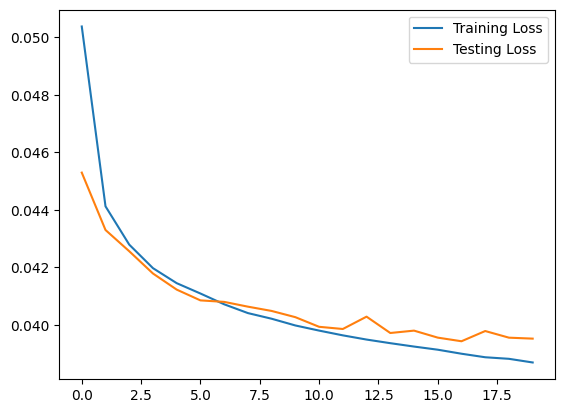

In [9]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Plot Generated Image

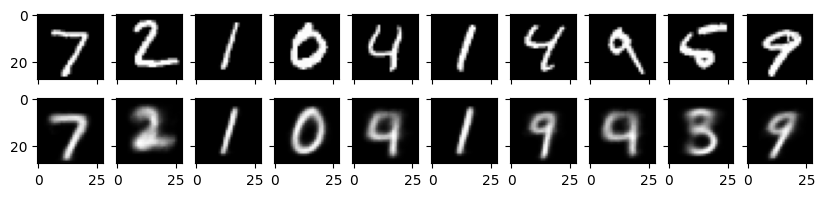

In [10]:
def plot_generated_images(data_loader,model,n_images=10):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(n_images,2))
    for idx, (input, _) in enumerate(data_loader):
        input = input.to(device)
        input = input[:n_images]
        reconstruction = model(input)
        for i in range(n_images):
            axes[0,i].imshow(input[i].cpu().detach().reshape((28,28)), cmap='gray')
            axes[1,i].imshow(reconstruction[i].cpu().detach().reshape((28,28)), cmap='gray')
        break

plot_generated_images(test_loader,model)
